# Eye State Recognition Using Alpha Waves

## Loading & Inspecting Dataset   

In [42]:
import dataset
import numpy as np
import pandas as pd 
from mne.preprocessing import ICA
from scipy.stats import kurtosis
import matplotlib.pyplot as plt 
from scipy.signal import welch
from detecta import detect_peaks 
import warnings
import mne
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
import xgboost as xgb
import tensorflow as tf
from tensorflow import keras
from keras.models import load_model
from sklearn.utils import resample
warnings.filterwarnings("ignore")
ch_names = ['Fp1','Fp2','FC5','Fz','FC6','T7','Cz','T8','P7','P3','Pz','P4','P8','O1','Oz','O2','stim']
# define the dataset instance
eeg_dataset = dataset.AlphaWaves() 
eeg_dataset.subject_list 

[1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

## Filtering Dataset Using Bandpass Filter

In [2]:
subjects_Filtered_data = list()

filter_type = 'bandpass'  
low_cutoff = 8  
high_cutoff = 12  
filter_order = 6

for i in eeg_dataset.subject_list:
    raw = eeg_dataset._get_single_subject_data(i).filter(l_freq=low_cutoff, h_freq=high_cutoff, picks='eeg', filter_length='auto',
           l_trans_bandwidth='auto', h_trans_bandwidth='auto', phase='zero',
           fir_design='firwin', skip_by_annotation=('edge', 'bad_acq_skip'),verbose = False)

    subjects_Filtered_data.append(raw)


## Denoising Using ICA 

### Inspection IC of Each Subject 

In this step, we will inspect the IC of each subject individually, and then accept or reject components based on visually inspection. We will mention the components that will be reject for each subject in `exclude_list`. 

In [3]:
exclude_list = [[0,3,4,6,11,14,15],[15,9,8],[0,1,3,5,9,10],[3,5,8,10],[0,2,4,6,13,11],
                [1,6,8,10,11,12,14],[1,2,3,4,5],[5,11,13,14],[0,2,3,5,11,14],[6,9,11,13,15],[12,7,2,0,3,6,5]
                ,[1,2,3,7],[0,1,3,6,10,12],[1,4,7,10,15,6],[0,2,3,5,12,13],[7,8,10,12,13],[5,6,7,10,12],[0,1,2,6,8,10,11,12]
                ,[0,2,4]] # by inspection 



assert len(eeg_dataset.subject_list) == len(exclude_list)

> Note: This exclude list can be used if you have followed the same defined `random_state` and `n_components` provided to `ica` object.  

In [4]:
def plot_subject_data(ica,subject_index,no_comp):
    raw_copy = subjects_Filtered_data[subject_index].copy()
    eeg_picks = raw_copy.pick_types(eeg = True)
    scalings = {'eeg': 15}
    eeg_picks.plot(scalings = scalings);
    ica.fit(raw_copy)
    ica.plot_components()
    ica.plot_properties(inst=raw_copy,picks = range(no_comp),verbose = False);
    return raw_copy

#### Example of Inspection  

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Using matplotlib as 2D backend.


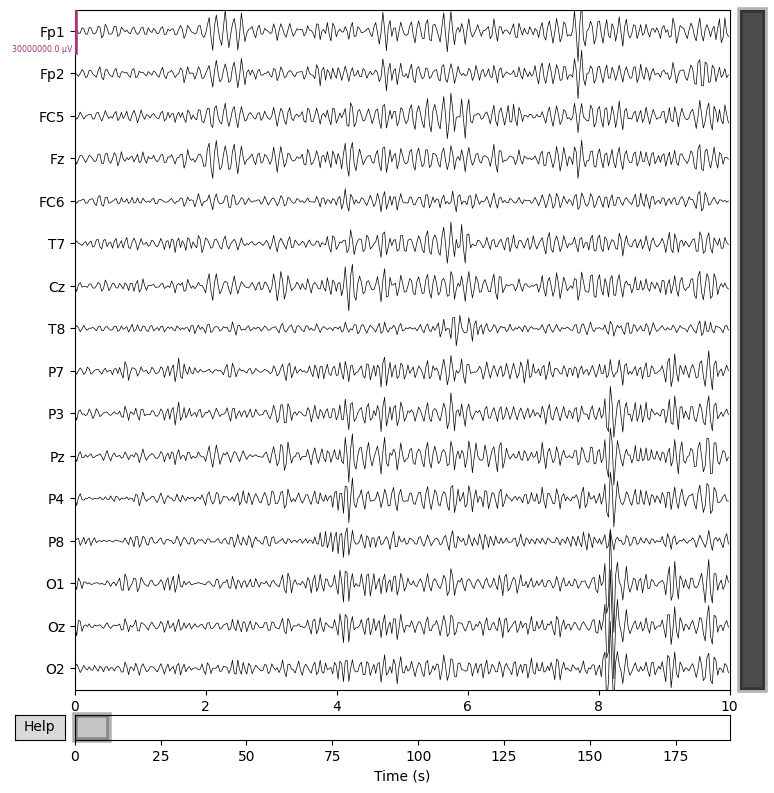

Fitting ICA to data using 16 channels (please be patient, this may take a while)
Selecting by number: 16 components
Fitting ICA took 1.7s.


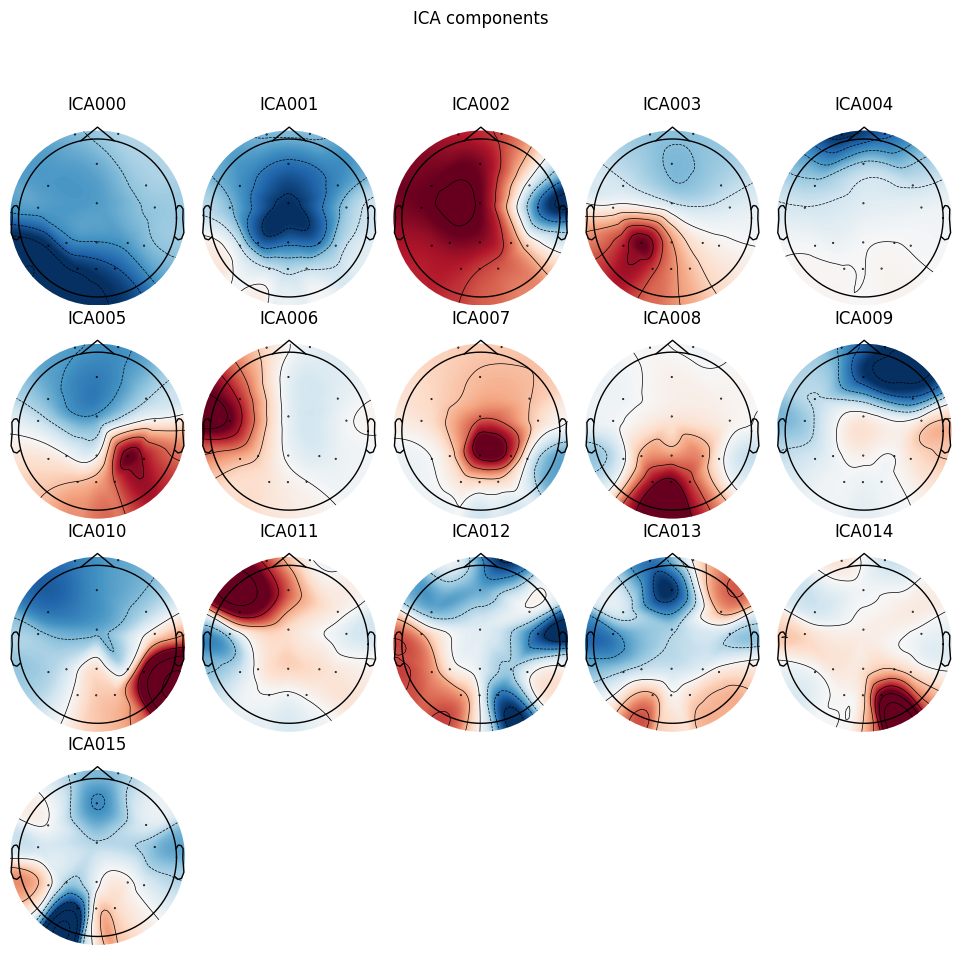

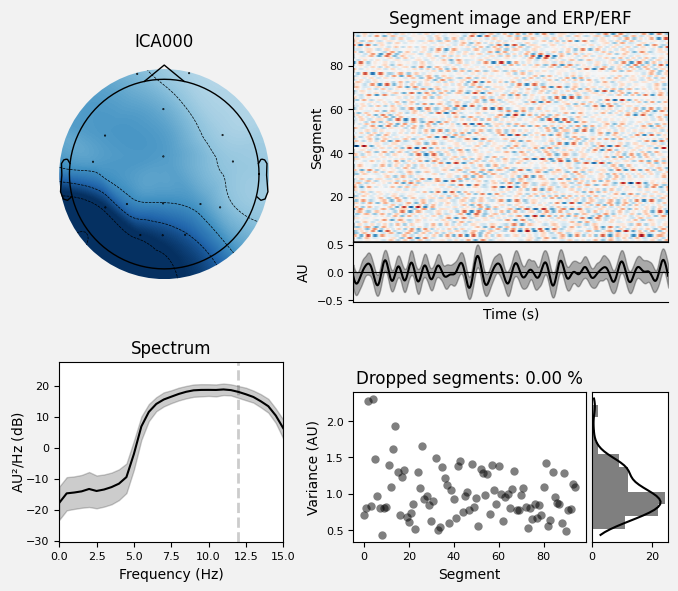

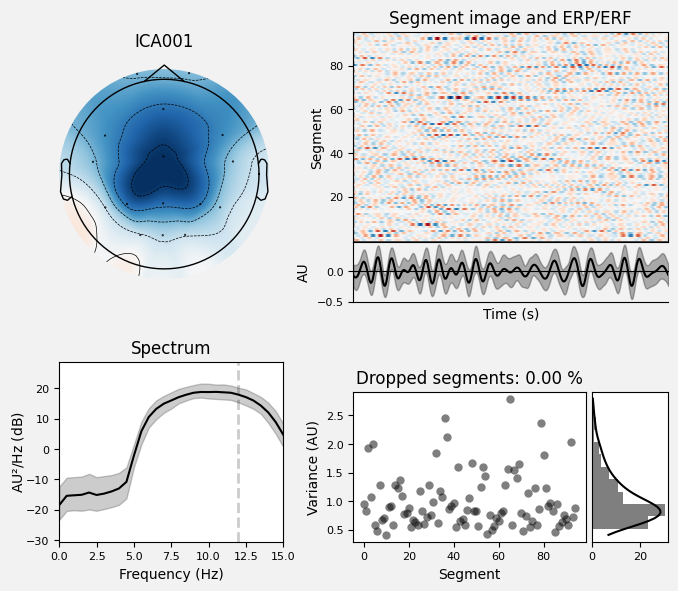

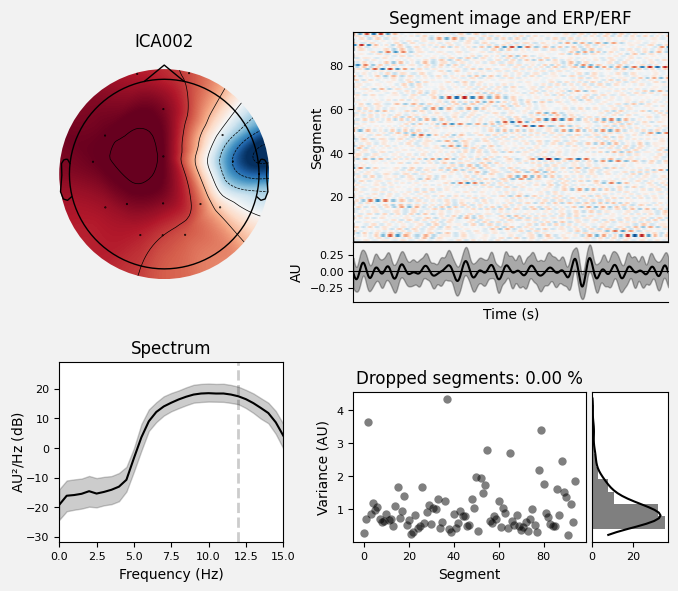

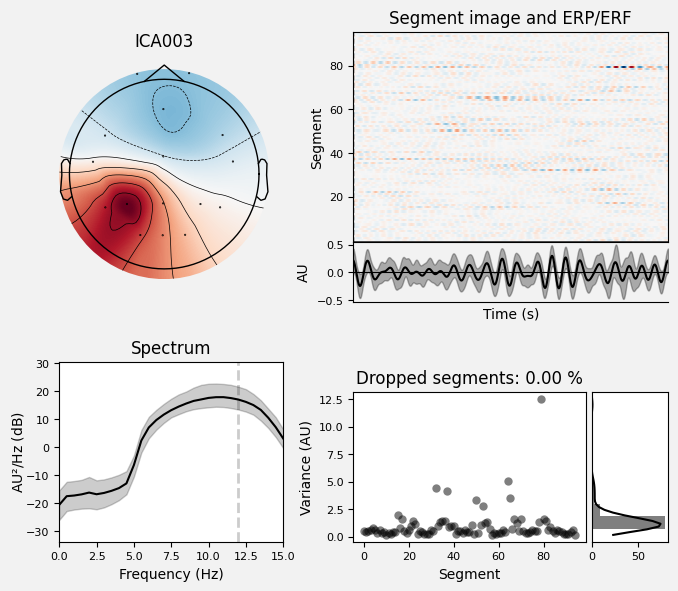

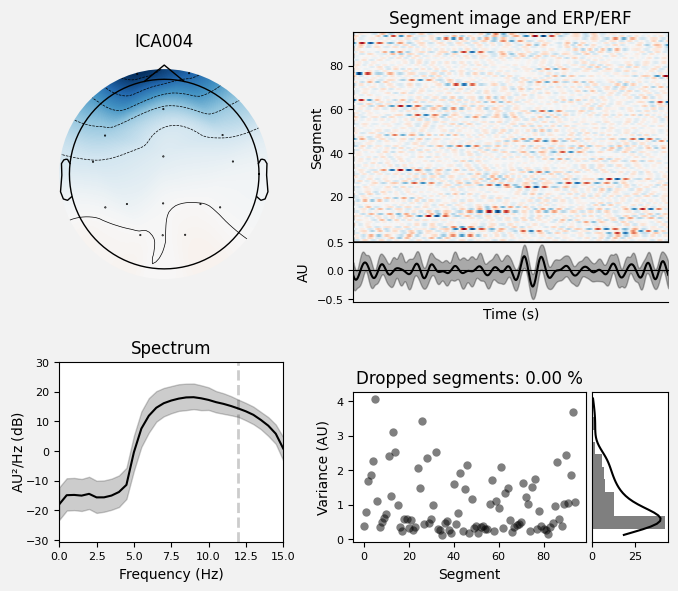

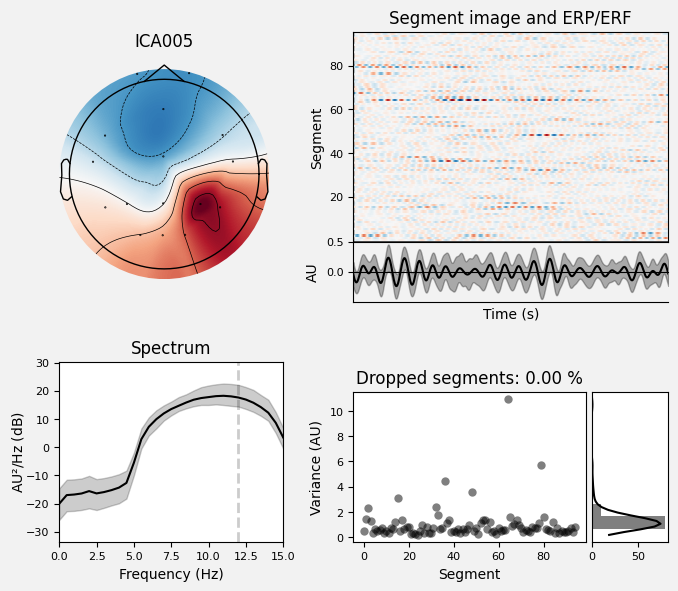

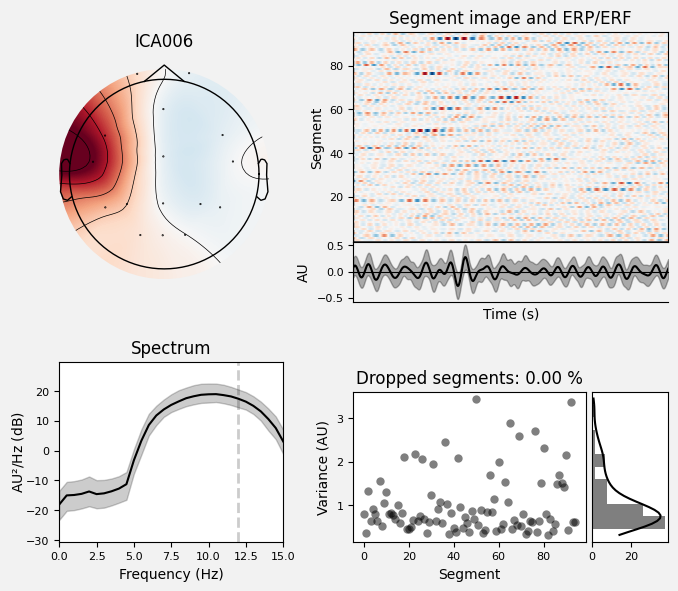

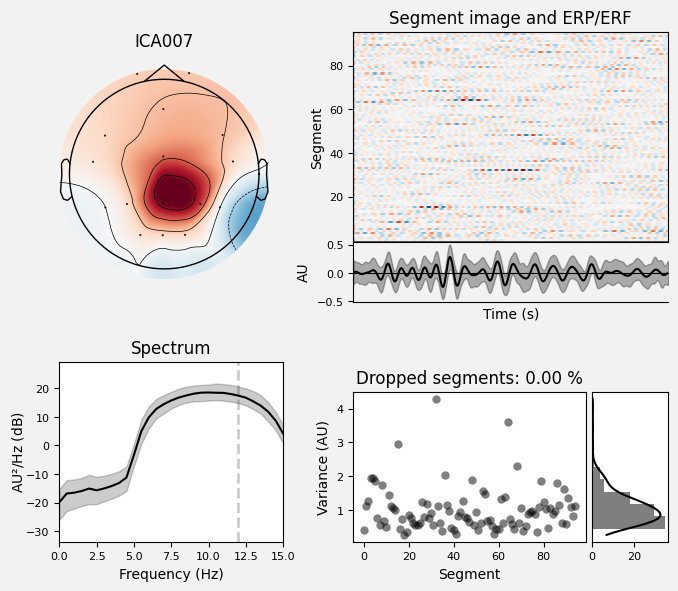

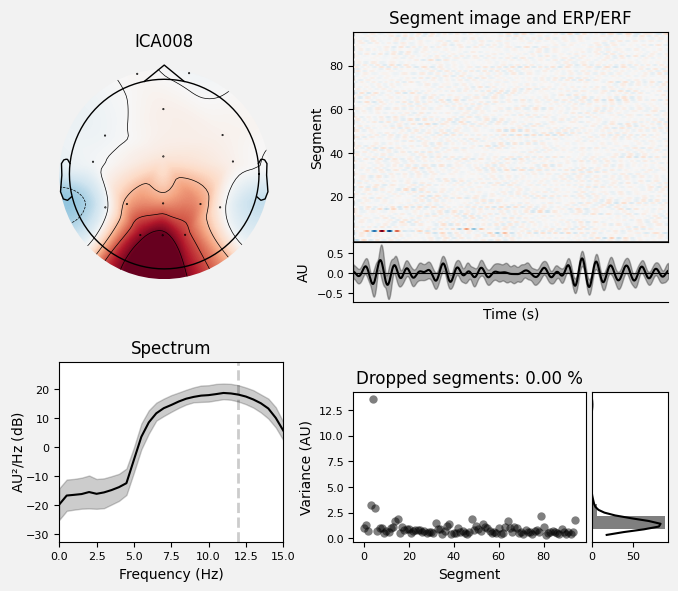

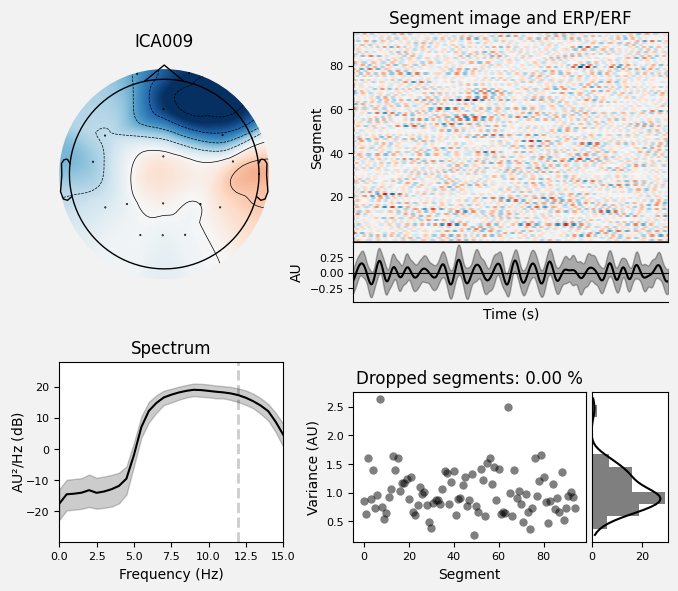

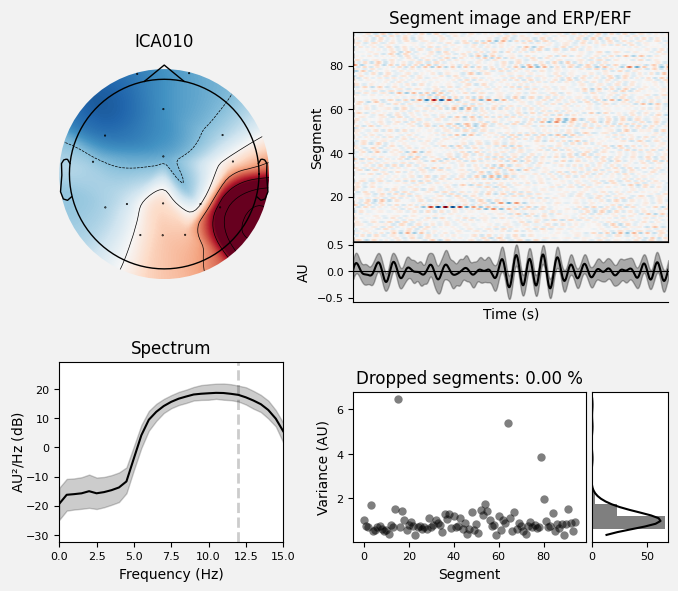

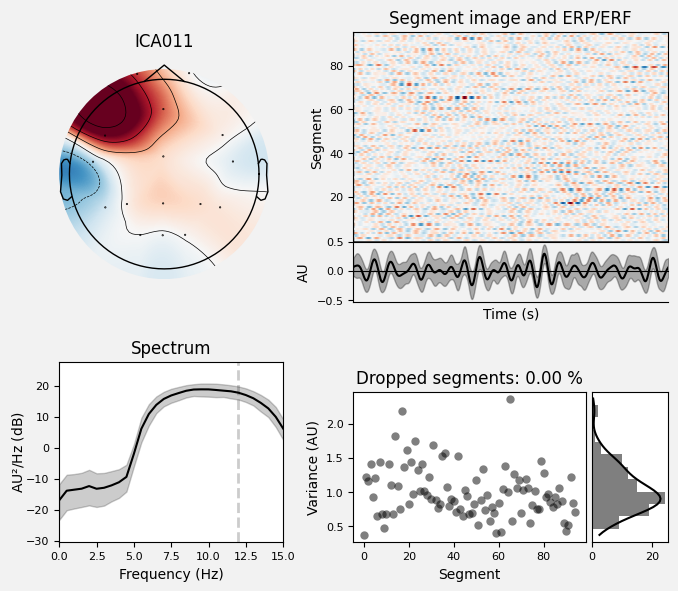

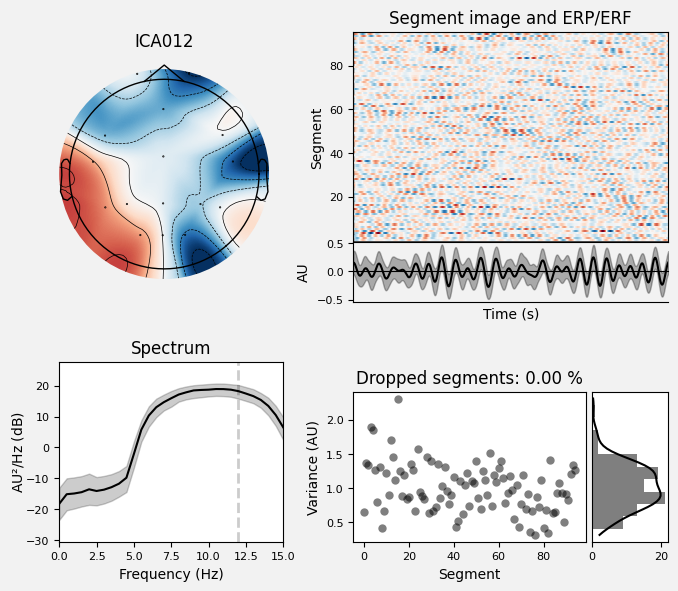

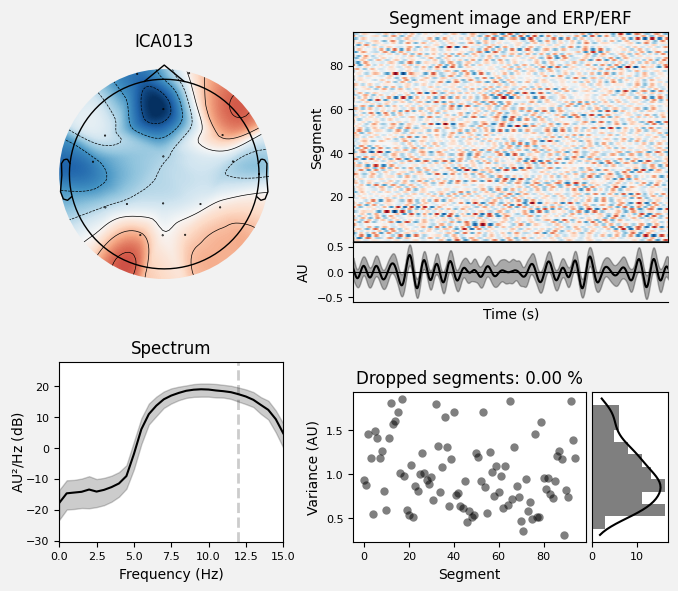

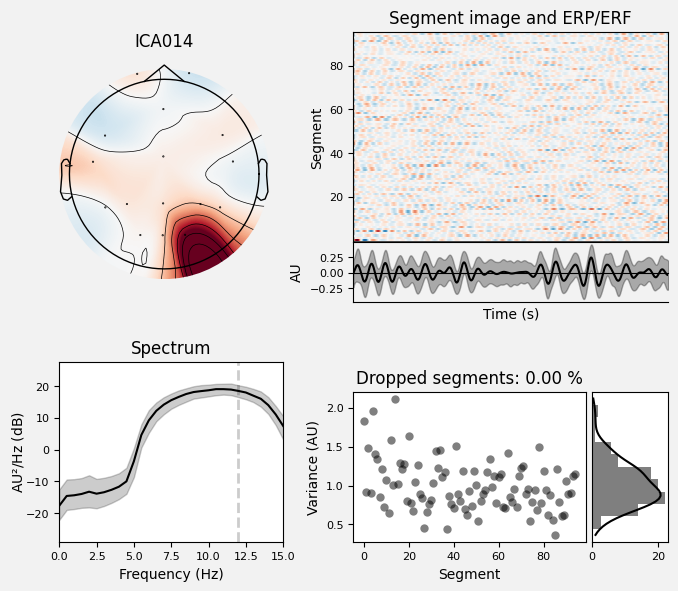

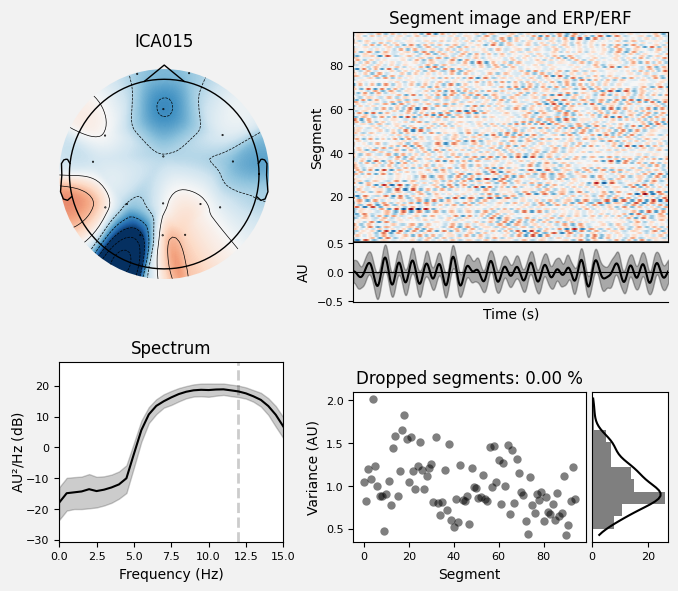

In [5]:
subject_index = 3
no_comp = 16
ica = ICA(n_components=no_comp, random_state=1)
raw_copy = plot_subject_data(ica,subject_index,no_comp)

Applying ICA to Raw instance
    Transforming to ICA space (16 components)
    Zeroing out 4 ICA components
    Projecting back using 16 PCA components
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


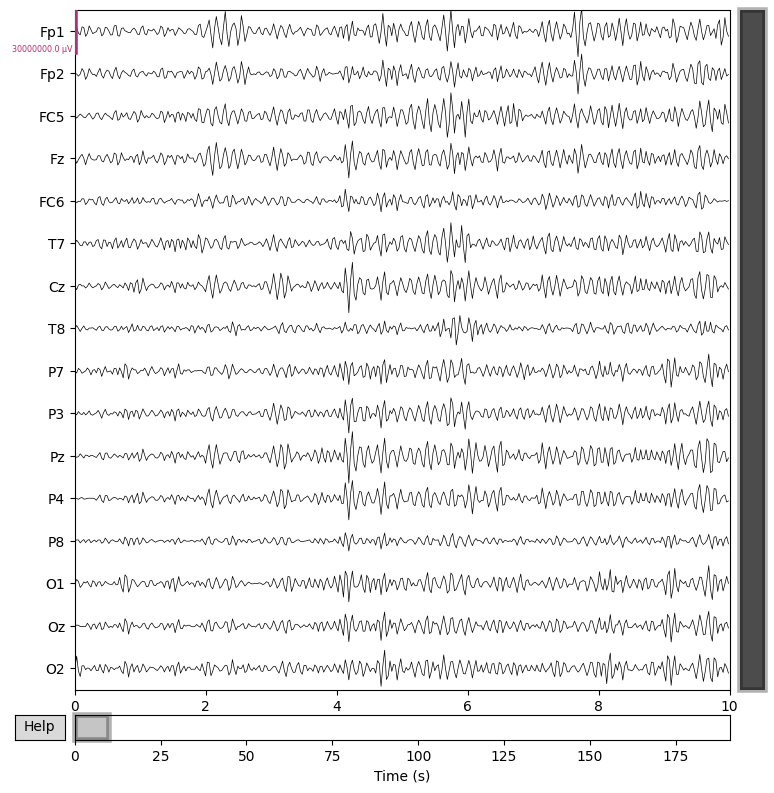

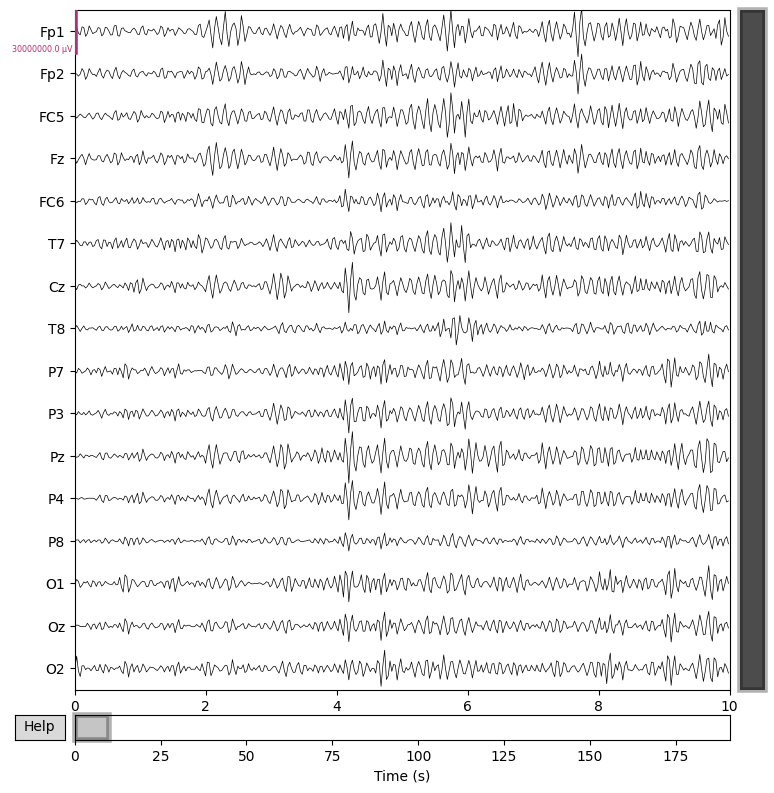

In [6]:
ica.exclude = exclude_list[subject_index]
ica.apply(raw_copy)
eeg_picks = raw_copy.pick_types(eeg = True)
scalings = {'eeg': 15}
eeg_picks.plot(scalings = scalings)

### Removing Artifacts 

In [7]:
cleaned_subjects_data = []
for i, raw in enumerate(subjects_Filtered_data):
    ica = ICA(n_components=16, random_state=1)
    cleaned_data = raw.copy()
    ica.fit(cleaned_data,verbose = False)
    ica.exclude = exclude_list[i]
    ica.apply(cleaned_data,verbose = False)
    cleaned_subjects_data.append(cleaned_data)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


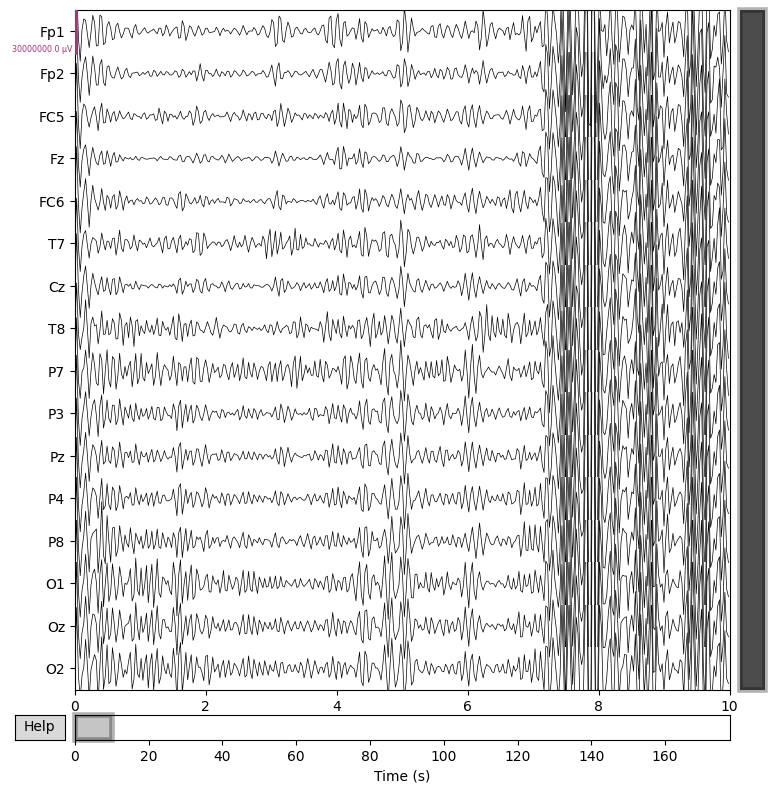

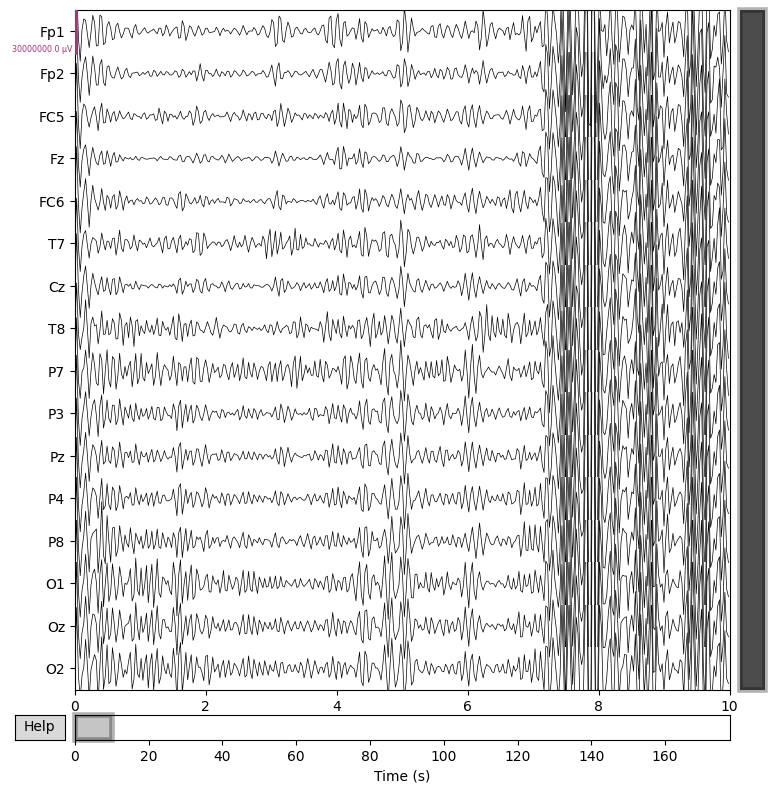

In [8]:
# plotting the channels of the subject 3 before applying ICA 
eeg_picks = subjects_Filtered_data[17].pick_types(eeg = True)
scalings = {'eeg': 15}
eeg_picks.plot(scalings = scalings)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


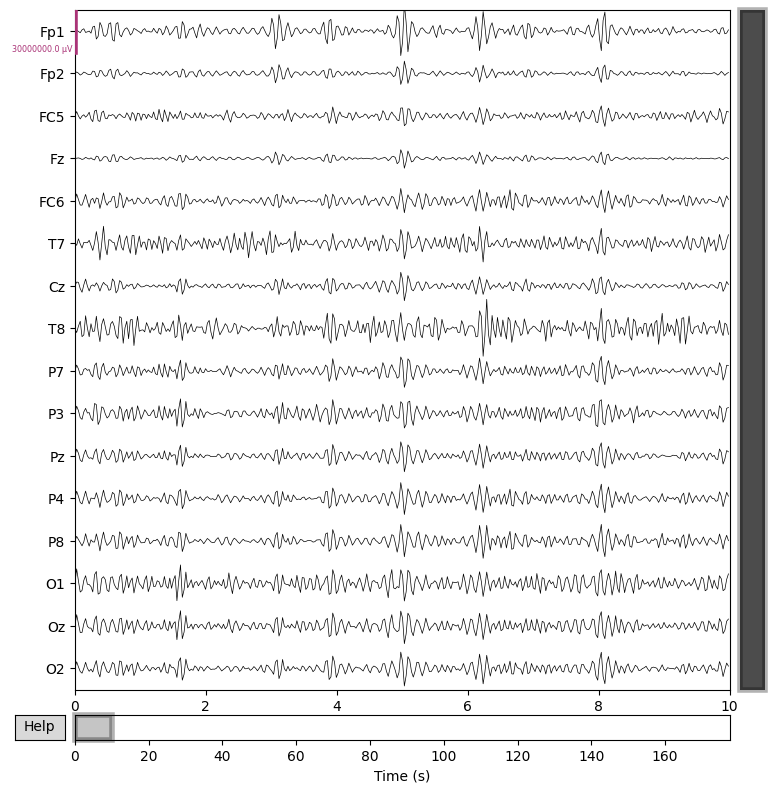

In [9]:
# plotting the channels of the subject 3 after applying ICA 
eeg_picks = cleaned_subjects_data[17].pick_types(eeg = True)
scalings = {'eeg': 15}
eeg_picks.plot(scalings = scalings);

## resampling & Epoching 

In [10]:
# let's consider just the first subject 
first_subject = cleaned_subjects_data[0].copy()
first_subject.resample(sfreq=128, verbose=False);

In [11]:
events = mne.find_events(raw=first_subject, shortest_event=1, verbose=False)
event_id = {'closed': 1, 'open': 2}
epochs = mne.Epochs(first_subject , events, event_id, tmin=2.0, tmax=8.0, baseline=(None,None),
                    verbose=False)
# epochs.load_data().pick_channels(["Oz"]);
epochs.load_data()
X_closed = epochs['closed'].get_data()
X_closed.shape


Using data from preloaded Raw for 10 events and 769 original time points ...
0 bad epochs dropped


(5, 17, 769)

### Estimate Averaged Spectra for Each Condition

In [12]:
X_closed = epochs['closed'].get_data()
f, S_closed = welch(X_closed, fs=epochs.info['sfreq'], axis=2) 
# S_closed = np.mean(S_closed, axis=0).squeeze()
S_closed[0][0].shape

(129,)

In [13]:
X_opened = epochs['open'].get_data()
f, S_opened = welch(X_opened, fs=epochs.info['sfreq'], axis=2)
# S_opened = np.mean(S_opened, axis=0).squeeze()
print(S_opened.squeeze().shape)
print(f.shape)
S_opened[0][0].shape

(5, 17, 129)
(129,)


(129,)

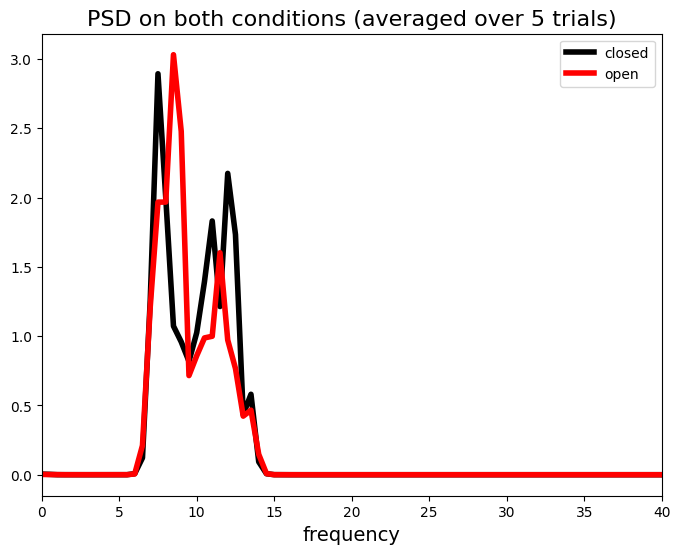

In [14]:
fig = plt.figure(facecolor='white', figsize=(8, 6))
plt.plot(f, S_closed[0][0], c='k', lw=4.0, label='closed')
plt.plot(f, S_opened[0][0], c='r', lw=4.0, label='open')
plt.xlim(0, 40)
plt.xlabel('frequency', fontsize=14)
plt.title('PSD on both conditions (averaged over 5 trials)', fontsize=16)
plt.legend()
plt.show()

### Applying Resampling and Epoching to all Subjects 

In [15]:
missing_data_object = cleaned_subjects_data[17]
cleaned_subjects_data.remove(missing_data_object)
epochs_list = list()
for subject in cleaned_subjects_data:
    subject_copy = subject.copy()
    subject_copy.resample(sfreq=128, verbose=False)
    events = mne.find_events(raw=subject_copy,stim_channel = 'stim', shortest_event=1, verbose=False)
    event_id = {'closed': 1, 'open': 2}
    epochs = mne.Epochs(subject_copy , events, event_id, tmin=2.0, tmax=8.0, baseline=(None,None),
                        verbose=False)
    epochs_list.append(epochs)

> While epoching the data, we have found that there are some missing data regarding subject **18**. So, we have excluded it.

In [16]:
print(missing_data_object.ch_names)

['Fp1', 'Fp2', 'FC5', 'Fz', 'FC6', 'T7', 'Cz', 'T8', 'P7', 'P3', 'Pz', 'P4', 'P8', 'O1', 'Oz', 'O2']


## Feature Extraction 

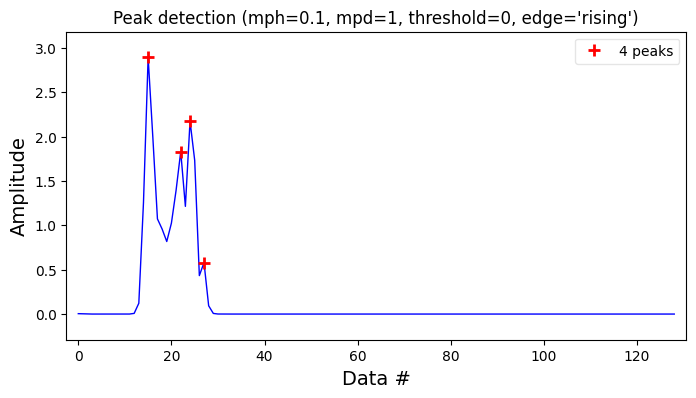

[ 7.5 11.  12.  13.5]
[2.89382696 1.83148381 2.17468125 0.58055569]


In [17]:
ind = detect_peaks(S_closed[0][0],mph = 0.1,show=True); 
print(f[ind])
print(S_closed[0][0][ind])

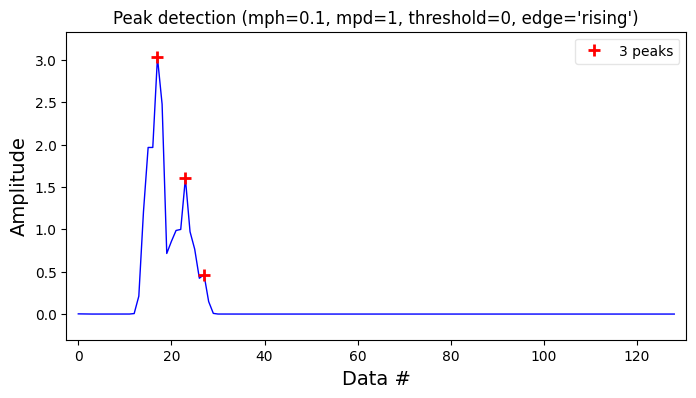

[ 8.5 11.5 13.5]
[3.03117798 1.60202673 0.46594414]


In [18]:
ind = detect_peaks(S_opened[0][0],mph = 0.1,show=True); 
print(f[ind])
print(S_opened[0][0][ind])

### Some Facility Functions 

In [19]:
def get_features(x_values,signal,mph): 
    """ extract some peaks from a transformed data at features.
            args:
                x_values: x-coordinate of the signal (i.e.,time difference & frequency)
                y_values: the transformed data (FFT, PSD or Autocorrelation values) 
                mph: the minimum peak height 
            
            return: 
                (peaks_x + peaks_y): a list of x and y coordinates concatenated 
    """
    indices_peaks = detect_peaks(signal,mph = mph) 
    peaks_x, peaks_y = get_first_n_peaks(x_values[indices_peaks],signal[indices_peaks])
    return peaks_x + peaks_y 

In [20]:
def get_first_n_peaks(x,y,no_peaks = 3): 
    """ Extract the first "n_peaks" peaks of the transformed signal. If the number of peaks
        is not sufficient it fills the rest with zeros. 
        
        args:
            x: the x-coordinate of the transformed signal (time difference or frequency)
            y: the transformed signal values
            n_peaks: the number of peaks to extract from the signal
    """
    x_,y_ = list(x),list(y)
    if len(x_) >= no_peaks:
        return x_[:no_peaks],y_[:no_peaks]
    else: # filling the rest values with zeros if it's not sufficient
        missing_no_peaks = no_peaks - len(x_)
        return x_ + [0]*missing_no_peaks, y_ + [0]*missing_no_peaks

*In upcoming cells, we will extract the features of each eye state individually*

In [21]:
# for closed eye state
closed_eye_signals = []
for epochs in epochs_list:
    epochs.load_data().pick_channels(ch_names[:-1])
    X_closed = epochs['closed'].get_data()
    for signal in X_closed:
        signal_features = list() # features list to which we are going to append our extracted features 
        for channel in signal:
            channel_feature = []
            # PSD features 
            f, S_closed = welch(channel, fs=epochs.info['sfreq'])
            PSD_features = get_features(f, S_closed,0.1) # 0.1 --> by inspection 
            # mean feature 
            # mean_val = np.mean(channel)
            # # variance feature
            variance_val = np.var(channel)
            channel_feature  = PSD_features + [variance_val]
            signal_features.append(channel_feature)
        signal_features = sum(signal_features,[]) 
        closed_eye_signals.append(signal_features)     

Using data from preloaded Raw for 10 events and 769 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Using data from preloaded Raw for 10 events and 769 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Using data from preloaded Raw for 10 events and 769 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Using data from preloaded Raw for 10 events and 769 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Using data from preloaded Raw for 10 events and 769 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Using data from preloaded Raw for 10 events and 769 original time points ...
0 bad epochs dropped
NOTE: pick_c

In [22]:
for signal in closed_eye_signals: # adding labels
    signal.append(1)
print((len(closed_eye_signals)))  
print((len(closed_eye_signals[0])))

90
113


In [23]:
open_eye_signals = []
for epochs in epochs_list:
    epochs.load_data().pick(ch_names[:-1])
    X_open = epochs['open'].get_data()
    for signal in X_open:
        signal_features = list() # features list to which we are going to append our extracted features 
        for channel in signal:
            channel_feature = []
            # PSD features 
            f, S_open = welch(channel, fs=epochs.info['sfreq'])
            PSD_features = get_features(f, S_open,0.1) # 0.1 --> by inspection 
            # mean feature 
            # mean_val = np.mean(channel)
            # # variance feature
            variance_val = np.var(channel)
            channel_feature  = PSD_features + [variance_val]
            signal_features.append(channel_feature)
        signal_features = sum(signal_features,[]) 
        open_eye_signals.append(signal_features) 

In [24]:
for signal in open_eye_signals: # adding labels
    signal.append(2)
print((len(open_eye_signals)))  
print((len(open_eye_signals[0])))

90
113


## Exporting our Data as CSV File

In [25]:
our_dataset = closed_eye_signals + open_eye_signals 
our_dataset = pd.DataFrame(our_dataset)
our_dataset.shape

(180, 113)

In [26]:
our_dataset.to_csv("Eye_state.csv")
our_dataset.head()

0     1     2         3         4         5          6    7     8     9    \
0  7.5  11.0  12.0  2.893827  1.831484  2.174681  10.261857  7.5  11.0  12.0   
1  9.5  12.0   0.0  2.473273  1.726224  0.000000   8.458026  9.5  11.5   0.0   
2  7.5  10.0  11.5  1.919186  1.616482  2.767268   9.594591  7.5  10.0  11.5   
3  8.0  10.0  11.0  2.996912  0.939468  1.216358   9.152589  8.0  10.0  12.5   
4  8.0   9.5  12.0  1.393033  2.544031  2.119056   8.946366  8.0   9.5  12.0   

   ...       103        104  105   106   107       108       109       110  \
0  ...  2.148544  10.884277  7.5  11.0  12.0  1.631225  4.910206  3.758243   
1  ...  1.792384   7.304274  7.5   9.5  11.5  0.700529  2.674954  3.592685   
2  ...  1.703749  16.123904  7.0   8.5  10.0  0.315671  0.911024  1.854688   
3  ...  3.211271  16.491077  7.5   8.5  10.0  1.226153  1.590267  4.026612   
4  ...  0.000000  10.522685  8.0  12.0   0.0  1.727207  7.823215  0.000000   

         111  112  
0  16.431155    1  
1  11.935992    1  
2  24.413363    1  
3  26.702535    1  
4  16.246967    1  

[5 rows x 113 columns]

# Modeling

In [27]:
our_dataset = our_dataset.sample(frac=1, random_state=5)

In [28]:
X = our_dataset.iloc[:, 0:112]
Y = our_dataset.iloc[:, 112]
Y = Y.replace(1, 0)
Y = Y.replace(2, 1)

In [29]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=1/6, random_state=5)

# Split the remaining data into validation (10%) and testing (20%)
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.67, random_state=5)

In [30]:
# Train a support vector machine (SVM) with a linear kernel
model = SVC(kernel='rbf')

# Train the model using the training set
model.fit(X_train, y_train)

# Validate the model using the validation set
y_val_pred = model.predict(X_val)
accuracy_val = accuracy_score(y_val, y_val_pred)
print("Validation Accuracy:", accuracy_val)

# Evaluate the model on the testing set
y_test_pred = model.predict(X_test)
accuracy_test = accuracy_score(y_test, y_test_pred)
print("Testing Accuracy:", accuracy_test)

# Calculate the confusion matrix to evaluate model performance
cm = confusion_matrix(y_test, y_test_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={'size': 16})
ax = plt.gca()

# Set custom labels for the x-axis and y-axis based on the distinct labels in the data
ax.set_xticklabels(sorted(["0", "1"]))
ax.set_yticklabels(sorted(["0", "1"]))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Calculate the F1 score to evaluate model performance
f1_svc = f1_score(y_test, y_test_pred, average='weighted')

print("F1 Score:", f1_svc)

NameError: name 'X_val' is not defined

In [ ]:
# Create a Random Forest model with specific hyperparameters
rf_model = RandomForestClassifier(
    n_estimators=100,            # Number of trees in the forest
    max_depth=10,                 # Maximum depth of each tree in the forest
    min_samples_split=2,          # Minimum number of samples required to split an internal node
    min_samples_leaf=1,           # Minimum number of samples required to be at a leaf node
    random_state=5                # Seed for random number generator for reproducibility
)

# Train the Random Forest model using the training set
rf_model.fit(X_train, y_train)

# Validate the Random Forest model using the validation set
y_val_pred = rf_model.predict(X_val)
accuracy_val = accuracy_score(y_val, y_val_pred)
print("Validation Accuracy:", accuracy_val)

# Evaluate the Random Forest model on the testing set
y_test_pred = rf_model.predict(X_test)
accuracy_test = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", accuracy_test)

# Calculate the F1 score to evaluate model performance
f1_svc = f1_score(y_test, y_test_pred, average='weighted')

print("F1 Score:", f1_svc)

Validation Accuracy: 0.8823529411764706
Test Accuracy: 0.7297297297297297
F1 Score: 0.724960254372019


Validation Accuracy: 0.8823529411764706
Test Accuracy: 0.7027027027027027


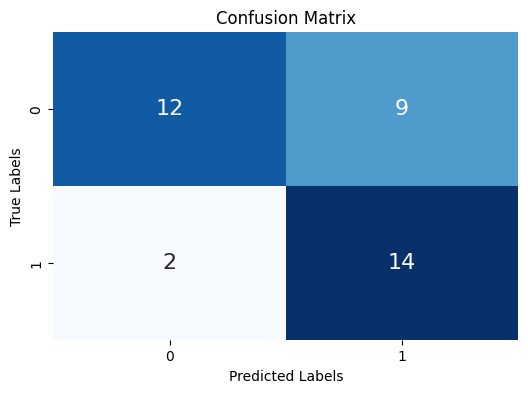

Misclassified Indices: [10 13 18 20 21 23 25 26 30 33 36]
F1 Score: 0.6996534996534997


In [ ]:
# Define the XGBoost model and its hyperparameters
xgb_model = xgb.XGBClassifier(
    learning_rate=0.1,        # Learning rate of the XGBoost model (step size during training)
    n_estimators=100,         # Number of boosting rounds (number of trees in the ensemble)
    max_depth=3,              # Maximum depth of each tree in the ensemble
    subsample=0.8,            # Subsample ratio of the training instances (for each tree)
    colsample_bytree=0.8,     # Subsample ratio of the features (for each tree)
    random_state=5            # Seed for random number generator for reproducibility
)

# Train the XGBoost model using the training set
xgb_model.fit(X_train, y_train)

# Validate the XGBoost model using the validation set
y_val_pred = xgb_model.predict(X_val)
accuracy_val = accuracy_score(y_val, y_val_pred)
print("Validation Accuracy:", accuracy_val)

# Evaluate the XGBoost model on the testing set
y_test_pred = xgb_model.predict(X_test)
accuracy_test = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", accuracy_test)

# Calculate the F1 score to evaluate XGBoost model performance
f1_xgb = f1_score(y_test, y_test_pred, average='weighted')

# Calculate the confusion matrix to evaluate XGBoost model performance
cm = confusion_matrix(y_test, y_test_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={'size': 16})
ax = plt.gca()

# Set custom labels for x-axis and y-axis based on the distinct labels in the data
ax.set_xticklabels(sorted(["1", "0"]))
ax.set_yticklabels(sorted(["1", "0"]))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Find the indices of misclassified instances
misclassified_indices_xgb = np.where(y_test_pred != y_test)[0]

# Print the indices of misclassified instances
print("Misclassified Indices:", misclassified_indices_xgb)

# Calculate the F1 score to evaluate model performance (already calculated above, but included for clarity)
f1_xgb = f1_score(y_test, y_test_pred, average='weighted')

# Print the F1 score
print("F1 Score:", f1_xgb)


In [64]:
def bootstrap():
    np.random.seed(42)
    num_bootstrap_samples = 1000  # You can adjust this number
# Training loop with different subsets
    for _ in range(num_bootstrap_samples):
        # Split your training data into subsets (e.g., using random sampling)
        subset_indices = np.random.choice(len(X_train), size=75, replace=False)
        X_subset = X_train.iloc[subset_indices].to_numpy().reshape(-1, 112)
        y_subset = y_train.iloc[subset_indices].to_numpy().reshape(-1, 1)
    
    yield X_subset, y_subset

    
# Define your neural network model
model = keras.Sequential([
    keras.layers.Input(shape=(112,)),  # Input layer

    # Hidden layers
    keras.layers.Dense(128, activation='relu'),
    # keras.layers.Dropout(0.3),  # Dropout layer for regularization
    keras.layers.Dense(64, activation='leaky_relu'),

    # Output layer
    keras.layers.Dense(2, activation='softmax')  # Binary classification (blink or not)
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Hyperparameters
num_epochs = 50
batch_size = 64

# Lists to store accuracy values for each subset
accuracies = []


# Train the model on the current subset
history = model.fit(bootstrap(), epochs=num_epochs, batch_size=batch_size, verbose=0)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
accuracies.append(test_accuracy)

# Calculate the mean and standard deviation of accuracies
mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)

print("Mean Accuracy:", mean_accuracy)
print("Standard Deviation of Accuracy:", std_accuracy)

Mean Accuracy: 1.0
Standard Deviation of Accuracy: 0.0


In [62]:
history.history["loss"]

[3.303941488265991, 0.0]

ValueError: x and y must have same first dimension, but have shapes (50,) and (2,)

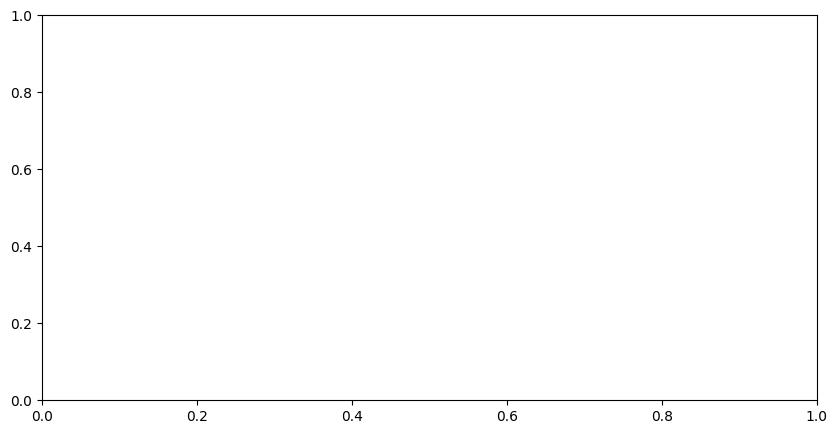

In [63]:
# Extract training and validation losses from the history
training_loss = history.history['loss']

# Create a range of epochs for the x-axis
epochs = range(1, num_epochs + 1)

# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(epochs, training_loss, label='Training Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [43]:
loaded = load_model("model.hdf5")

In [49]:
loaded.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 128)               14464     
                                                                 
 dense_25 (Dense)            (None, 64)                8256      
                                                                 
 dense_26 (Dense)            (None, 2)                 130       
                                                                 
Total params: 22850 (89.26 KB)
Trainable params: 22850 (89.26 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [55]:
test_loss, test_accuracy = loaded.evaluate(X_test, y_test, verbose=0)
test_accuracy * 100

96.66666388511658